In [2]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
DATASET_PATH = '/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/*'

# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_butterflies_256_256.hdf5'
# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_butterflies_256_256_damaged_classes.hdf5'
# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_cat_focal_loss.hdf5'
# MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_data_augmentation_class_weights_cat_cross_entropy_loss_RGB.hdf5'
MODEL_SAVE_PATH = '/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_data_augmentation_class_weights_cat_cross_entropy_loss_grayscale.hdf5'

SIZE_X = 256
SIZE_Y = 256

# n_classes=16 #Number of classes for segmentation - damaged version
n_classes=11 #Number of classes for segmentation

# IMG_CHANNELS = 3 #for color images
IMG_CHANNELS = 1 #for grayscale

MODEL_LOSS = 'categorical_crossentropy'
#MODEL_LOSS = 'categorical_focal_crossentropy'

GRAY_SCALE = True
# GRAY_SCALE = False

## Load in Dataset Images

In [4]:
#file types
file_extensions = ["png"] #["jpg", "JPG", "jpeg", "png"]

#Get training images and mask paths then sort
image_filepaths = []
for directory_path in glob.glob(DATASET_PATH):
  print(directory_path)
  for ext in file_extensions:
    for img_path in glob.glob(os.path.join(directory_path, f"*.{ext}")):
      image_filepaths.append(img_path)

#sort image and mask fps to ensure we have the same order to index
image_filepaths.sort()

#get actual masks and images
dataset_images = []

for img_path in image_filepaths:
  if GRAY_SCALE:
    img = cv2.imread(img_path, 0)
  else:
    img = cv2.imread(img_path)
  dataset_images.append(img)

#Convert list to array for machine learning processing
dataset_images = np.array(dataset_images)

/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius erato ssp. amalfreda
/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius melpomene ssp. malleti
/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius erato ssp. cyrbia
/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius erato ssp. dignus
/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius melpomene ssp. rosina
/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius erato ssp. phyllis
/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius erato ssp. reductimacula
/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius erato ssp. notabilis
/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius melpomene ssp. thelxiopeia
/content/drive/MyDrive/annotation_data/jiggins/jiggins_data_256_256/Heliconius erato ssp. hydar

In [6]:
len(image_filepaths)

4686

In [7]:
len(dataset_images)

4686

#Load in our model

In [15]:
# https://youtu.be/XyX5HNuv-xE
# https://youtu.be/q-p8v1Bxvac
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
  #comment
  # Build the model
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs

  #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  #NOTE: Compile the model in the main program to make it easy to test with various loss functions
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()

  return model

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=IMG_CHANNELS)

In [16]:
# Load in trained model
print(MODEL_SAVE_PATH)
model_save_path = MODEL_SAVE_PATH
model = get_model()
model.compile(optimizer='adam', loss= MODEL_LOSS, metrics=['accuracy'])
model.load_weights(model_save_path)

/content/drive/MyDrive/annotation_data/unet_models/unet_butterflies_256_256_corrected_orientation_data_augmentation_class_weights_cat_cross_entropy_loss_grayscale.hdf5


# Preprocess Images

In [17]:
classes = {
  0: 'background',
  1: 'generic',
  2: 'right_forewing',
  3: 'left_forewing',
  4: 'right_hindwing',
  5: 'left_hindwing',
  6: 'ruler',
  7: 'white_balance',
  8: 'label',
  9: 'color_card',
  10: 'body'}

In [18]:
#preprocess all images so we can use our model on them
if IMG_CHANNELS == 1:
  print('expanding dimensions for images')
  normalized_dataset_images = np.expand_dims(dataset_images, axis=3)
  normalized_dataset_images = normalize(normalized_dataset_images, axis=1)
else:
  normalized_dataset_images = normalize(dataset_images, axis=1)

expanding dimensions for images


In [19]:
normalized_dataset_images.shape

(4686, 256, 256, 1)

## Predict Masks, and Extract and Save Wings for Each Image

In [20]:
def save_segmented_wings(test_img, predicted_img, cropped_dim=(256, 256)):
  cropped_wings = dict()
  cropped_wings_resized = dict()

  #only saving non-damaged wings when you predict with the model trained on damaged classes
  for wing_class in [2,3,4,5]:
    img = test_img[:,:, 0]
    mask = np.asarray(predicted_img==wing_class, dtype=int) #0s and 1s

    # cropped = img * mask
    # plt.imshow(cropped, cmap='gray')
    # plt.show()

    y_coords = []
    x_coords = []
    for y in range(0, mask.shape[0]):
      for x in range(0, mask.shape[1]):
        if mask[y,x]==1:
          x_coords.append(x)
          y_coords.append(y)

    #our mask is empty - therefore no existing mask for that wing
    if len(x_coords) == 0 and len(y_coords) == 0:
      continue

    x_coords.sort()
    y_coords.sort()

    miny = y_coords[0]
    maxy = y_coords[-1]
    minx = x_coords[0]
    maxx= x_coords[-1]

    #get boundaries with some extra room
    if y_coords[0] > 10 and x_coords[0] > 10:
      miny -= 10
      maxy += 10
      minx -= 10
      maxx += 10

    cropped_result = img[miny:maxy, minx:maxx]
    cropped_result_resized = cv2.resize(cropped_result, cropped_dim, interpolation=cv2.INTER_CUBIC)

    cropped_wings[wing_class] = cropped_result #not resizing yet
    cropped_wings_resized[wing_class] = cropped_result_resized

  return cropped_wings, cropped_wings_resized


In [21]:
classes = {0: 'background',
  1: 'generic',
  2: 'right_forewing',
  3: 'left_forewing',
  4: 'right_hindwing',
  5: 'left_hindwing',
  6: 'ruler',
  7: 'white_balance',
  8: 'label',
  9: 'color_card',
  10: 'body'}

dataset_segmented = pd.DataFrame(columns = ['image', 'background',
                                            'generic', 'right_forewing',
                                            'left_forewing', 'right_hindwing',
                                            'left_hindwing', 'ruler', 'white_balance',
                                            'label', 'color_card', 'body', 'damaged'])

In [ ]:
# folder = '/content/drive/MyDrive/annotation_data/jiggins_masks/jiggins_masks_data_256_256/Heliconius erato ssp. lativitta'
# os.makedirs(folder, exist_ok=True)

### Predict masks and save forewings with model NOT trained on damaged classes

In [22]:
i = 0 #dataframe indexer
errors = []
for test_img, fp in zip(normalized_dataset_images, image_filepaths):
  #predict the mask on the image
  test_img_norm=test_img[:,:,0][:,:,None]
  test_image_input = np.expand_dims(test_img_norm, 0)
  prediction = (model.predict(test_image_input))
  predicted_img = np.argmax(prediction, axis=3)[0,:,:]

  #save mask
  mask_path = fp.replace('jiggins', 'jiggins_masks')
  mask_path = mask_path.replace('.png', '_mask.png')

  mask_fn = "/" + mask_path.split('/')[-1]
  mask_folder = mask_path.replace(mask_fn, "")
  os.makedirs(mask_folder, exist_ok=True)

  plt.imsave(mask_path, predicted_img)

  #enter relevant segmentation data for the image
  classes_in_image = np.unique(predicted_img)
  classes_not_in_image = set(classes.keys()) ^ set(classes_in_image)
  dataset_segmented.loc[i, 'image'] = fp

  for val in classes_in_image:
    pred_class = classes[val]
    dataset_segmented.loc[i, pred_class] = 1 #class exists in segmentation

  for not_pred_val in classes_not_in_image:
    not_pred_class = classes[not_pred_val]
    dataset_segmented.loc[i, not_pred_class] = 0 #class does not exist in segmentation

  #crop + extract any existing wings
  cropped_wings, cropped_wings_resized = save_segmented_wings(test_img, predicted_img)

  #save each individual wing with a traceable name to the source image (ex. erato_0001_right_forewing.png)
  for wing_idx in cropped_wings.keys():
    cropped_wing = cropped_wings[wing_idx]
    cropped_wing_resized = cropped_wings_resized[wing_idx]

    cropped_wing_path = fp.replace('/jiggins/', '/cropped_wings/jiggins/').replace('.png', f'_wing_{wing_idx}.png')
    resized_cropped_wing_path = fp.replace('/jiggins/', '/cropped_wings_256_256/jiggins/').replace('.png', f'_wing_{wing_idx}.png')

    n = "/" + cropped_wing_path.split('/')[-1]
    cropped_wing_folder = cropped_wing_path.replace(n, "")
    os.makedirs(cropped_wing_folder, exist_ok=True)

    r = "/" + resized_cropped_wing_path.split('/')[-1]
    resized_cropped_wing_folder = resized_cropped_wing_path.replace(r, "")
    os.makedirs(resized_cropped_wing_folder, exist_ok=True)

    try:
      plt.imsave(cropped_wing_path, cropped_wing)
      plt.imsave(resized_cropped_wing_path, cropped_wing_resized)
    except FileNotFoundError:
      errors.append(cropped_wing_path)

    i += 1

1/1 [==============================] - 0s 107ms/step


In [23]:
print('Errors saving: ', errors)
dataset_segmented

Errors saving:  []


,image,background,generic,right_forewing,left_forewing,right_hindwing,left_hindwing,ruler,white_balance,label,color_card,body,damaged
0,/content/drive/MyDrive/annotation_data/jiggins...,1,0,1,1,1,1,1,0,1,0,0,NaN
4,/content/drive/MyDrive/annotation_data/jiggins...,1,0,1,1,1,1,1,0,1,0,0,NaN
8,/content/drive/MyDrive/annotation_data/jiggins...,1,0,1,1,1,1,1,0,1,0,0,NaN
12,/content/drive/MyDrive/annotation_data/jiggins...,1,0,1,1,1,1,1,0,1,0,0,NaN
16,/content/drive/MyDrive/annotation_data/jiggins...,1,0,1,1,1,1,1,0,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18364,/content/drive/MyDrive/annotation_data/jiggins...,1,0,1,1,1,1,1,0,1,0,0,NaN
18368,/content/drive/MyDrive/annotation_data/jiggins...,1,0,1,1,1,1,1,0,1,0,0,NaN
18372,/content/drive/MyDrive/annotation_data/jiggins...,1,0,1,1,1,1,1,0,1,0,0,NaN
18376,/content/drive/MyDrive/annotation_data/jiggins...,1,0,1,1,1,1,1,0,1,0,0,NaN


In [24]:
dataset_segmented.to_csv('/content/drive/MyDrive/annotation_data/jiggins_masks/segmented_jiggins_dataset_metadata.csv', index=False)

# Visualize Masks

In [10]:
def load_dataset_images(dataset_path):
    '''Load in actual images from filepaths from all subfolders in the provided dataset_path'''
    #file types
    file_extensions = ["png"] #["jpg", "JPG", "jpeg", "png"]

    #Get training image paths then sort
    image_filepaths = []
    for directory_path in glob.glob(dataset_path):
        if os.path.isfile(directory_path):
            image_filepaths.append(directory_path)
        elif os.path.isdir(directory_path):
            for ext in file_extensions:
                for img_path in glob.glob(os.path.join(directory_path, f"*.{ext}")):
                    image_filepaths.append(img_path)

    #sort image and mask fps to ensure we have the same order to index
    image_filepaths.sort()

    #get actual masks and images
    dataset_images = []

    for img_path in image_filepaths:
        img = cv2.imread(img_path, 0)
        dataset_images.append(img)

    #Convert list to array for machine learning processing
    dataset_images = np.array(dataset_images)
    return dataset_images, image_filepaths

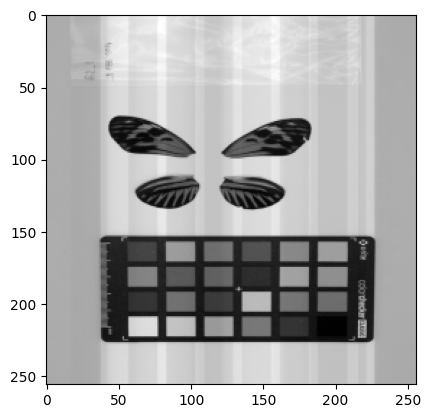

In [44]:
dataset_images, image_filepaths = load_dataset_images("/fs/ess/PAS2136/Butterfly/butterfly_image_segmentation/neil_butterfly_data_256_256")

normalized_dataset_images = np.expand_dims(dataset_images, axis=3)
normalized_dataset_images = normalize(normalized_dataset_images, axis=1)

test_img = normalized_dataset_images[0]
fp = image_filepaths[0]
# for test_img, fp in zip(normalized_dataset_images, image_filepaths):
    #use the unet model to predict the mask on the image
test_img_norm = test_img[:,:,0][:,:,None]
test_image_input = np.expand_dims(test_img_norm, 0) #add batch dimension

test_img_norm.shape
plt.imshow(test_img_norm, cmap='gray')


# prediction = (model.predict(test_image_input))
# predicted_img = np.argmax(prediction, axis=3)[0,:,:]

/fs/ess/PAS2136/Butterfly/butterfly_image_segmentation/neil_butterfly_data_256_256_masks/b3_6_720_mask.png


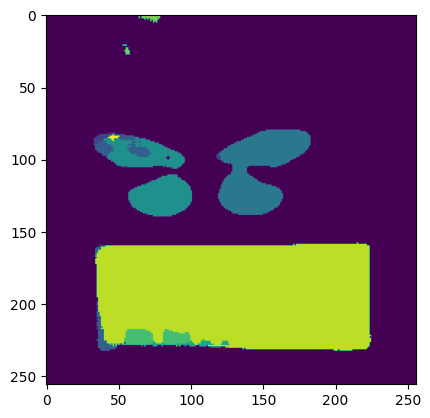

In [46]:
dataset_images, image_filepaths = load_dataset_images("/fs/ess/PAS2136/Butterfly/butterfly_image_segmentation/neil_butterfly_data_256_256_masks")
predicted_img = dataset_images[6]
plt.imshow(predicted_img)

print(image_filepaths[6])

In [36]:
id2label = {0: 'background',
  1: 'generic',
  2: 'right_forewing',
  3: 'left_forewing',
  4: 'right_hindwing',
  5: 'left_hindwing',
  6: 'ruler',
  7: 'white_balance',
  8: 'label',
  9: 'color_card',
  10: 'body'}

# y = 75
# x = 175

# y = 200
# x = 175

y = 50
x = 50

print('\nPredicted label')
print(f'pixel value:           {predicted_img[y, x]}')
print(f'category   :           {id2label[predicted_img[y,x]]}')


Predicted label
pixel value:           0
category   :           background


In [25]:
fps[0]

'/fs/ess/PAS2136/Butterfly/butterfly_image_segmentation/neil_butterfly_data_256_256_masks/b2_1_720_mask.png'